In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [ ]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nuclease_design import utils
from nuclease_design import constants
from nuclease_design import plotting

# Constants

In [ ]:
sns.set(font_scale=2)
sns.set_style('ticks')

In [ ]:
DATA_DIR = constants.DATA_DIR

# Library code

In [ ]:
DEFAULT_MAX_INTRA_CLUSTER_HAMMING_DISTANCE = 3

def print_library_sizes(df, hit_calling_kwargs, max_intra_cluster_hamming_distance=DEFAULT_MAX_INTRA_CLUSTER_HAMMING_DISTANCE):
  print('Input library')
  print('size:')
  print(df['sublibrary_name'].value_counts())
  print('num clusters:')
  print(df.groupby('sublibrary_name')['sequence'].apply(utils.num_sequence_clusters, max_intra_cluster_hamming_distance))

  print('Hits')
  hit_df = df.groupby('sublibrary_name').apply(utils.select_hit_rows, **hit_calling_kwargs).reset_index(drop=True)
  print('size:')
  print(hit_df['sublibrary_name'].value_counts())
  print('num clusters:')
  print(hit_df.groupby('sublibrary_name')['sequence'].apply(utils.num_sequence_clusters, max_intra_cluster_hamming_distance))


# Load data

In [ ]:
all_data_df = utils.load_all_data(data_dir=DATA_DIR)
df = utils.expand_sublibraries(all_data_df)
df['campaign'] = df['sublibrary_name'].apply(lambda s: 'HR' if s.endswith('recombination') else 'ML')

with utils.open_file(constants.NUM_CLUSTERS_G4_PATH, 'r', DATA_DIR) as f:
  num_clusters_g4_df = pd.read_csv(f)

with utils.open_file(constants.NUM_CLUSTERS_ZERO_SHOT_PATH, 'r', DATA_DIR) as f:
  num_clusters_zero_shot_df = pd.read_csv(f)

# G4 MBO_DNN vs. Baseline

In [ ]:
g4_comparison_df = df[df['sublibrary_name'].isin(['g4_mbo_dnn', 'g4_hit_recombination'])]

In [ ]:
hit_calling_kwargs = dict(
    reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(g4_comparison_df, hit_calling_kwargs)

Input library
size:
g4_hit_recombination    1540
g4_mbo_dnn              1356
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination    501
g4_mbo_dnn              858
Name: sequence, dtype: int32
Hits
size:
g4_mbo_dnn              1146
g4_hit_recombination     890
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination    297
g4_mbo_dnn              733
Name: sequence, dtype: int32


In [ ]:
hit_calling_kwargs = dict(
    reference_name='a73r', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(g4_comparison_df, hit_calling_kwargs)

Input library
size:
g4_hit_recombination    1540
g4_mbo_dnn              1356
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination    501
g4_mbo_dnn              858
Name: sequence, dtype: int32
Hits
size:
g4_mbo_dnn              52
g4_hit_recombination     8
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g4_hit_recombination     5
g4_mbo_dnn              42
Name: sequence, dtype: int32


In [ ]:
# add pre-sort label
num_clusters_g4_df['activity_label'] = num_clusters_g4_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)
num_clusters_g4_df.head()

,campaign,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population
0,HR,0,979,pre-sort,0,pre-sort
1,HR,1,958,pre-sort,0,pre-sort
2,HR,2,972,pre-sort,0,pre-sort
3,HR,3,980,pre-sort,0,pre-sort
4,HR,4,952,pre-sort,0,pre-sort


In [ ]:
# rename
num_clusters_g4_df['population'] = num_clusters_g4_df['activity_label'].astype(str)
num_clusters_g4_df['population'] = num_clusters_g4_df['population'].str.replace('a73r', 'A73R')

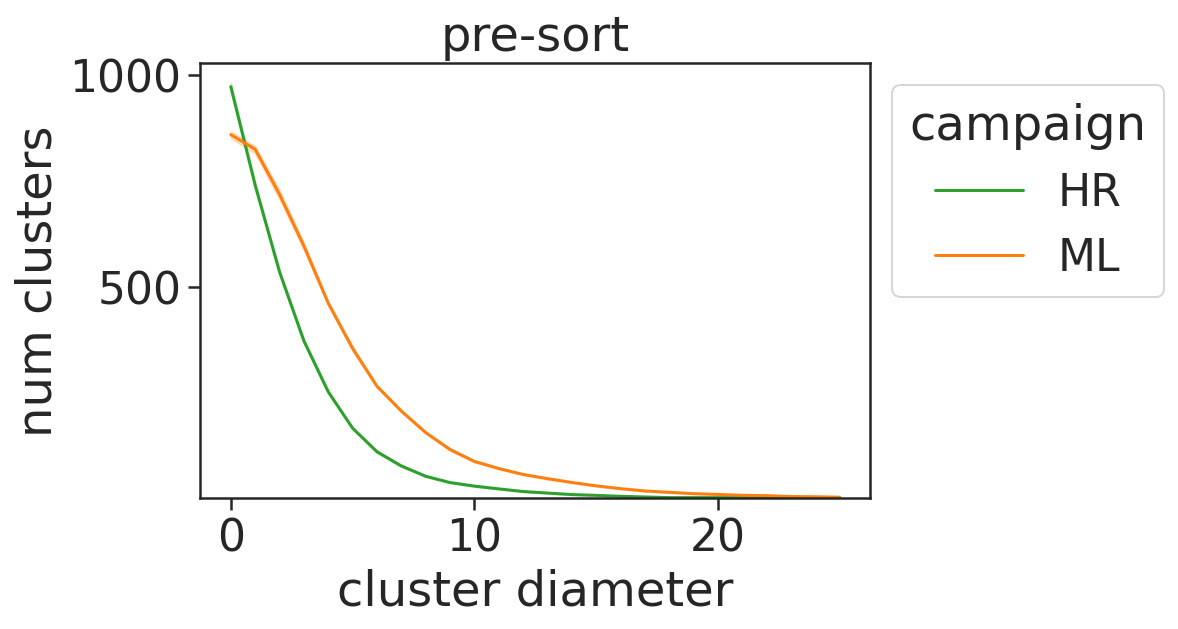

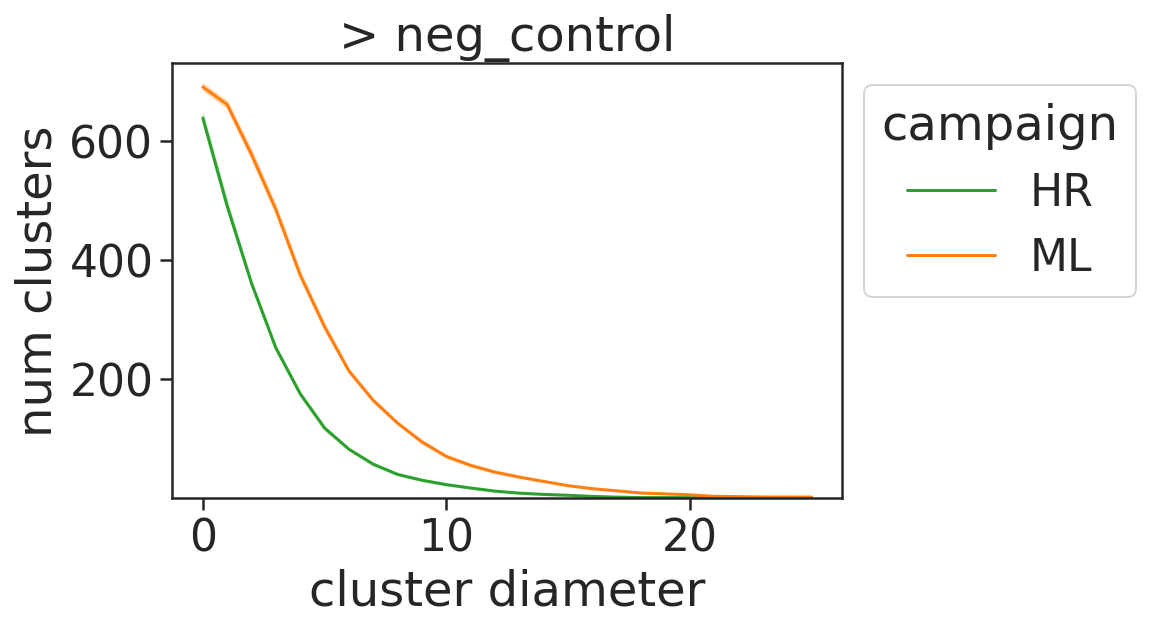

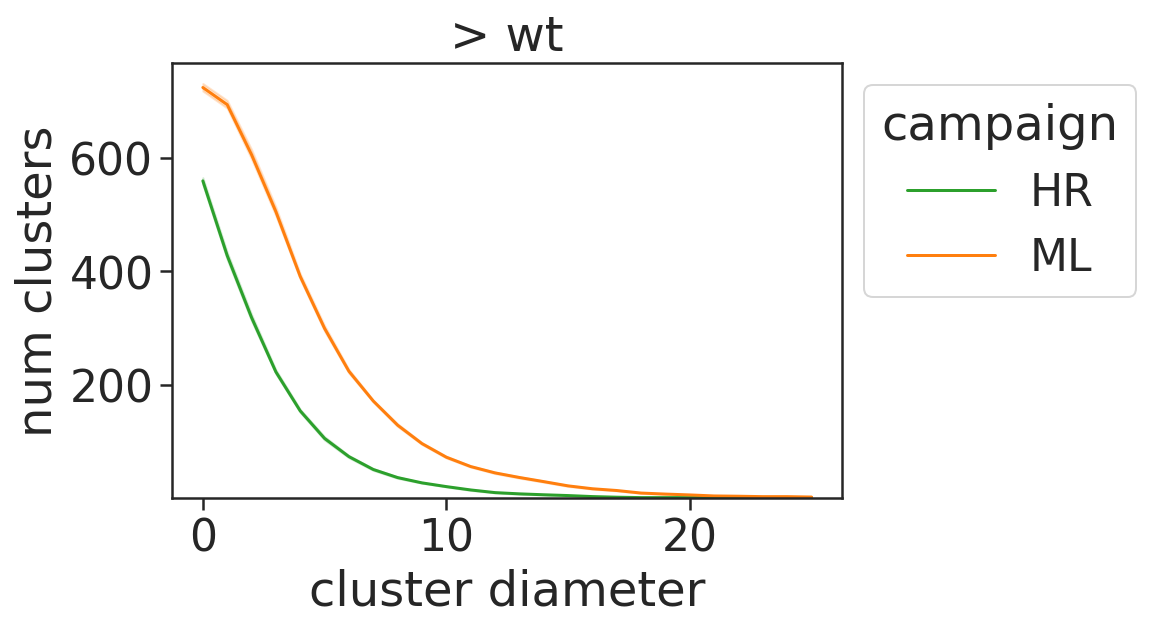

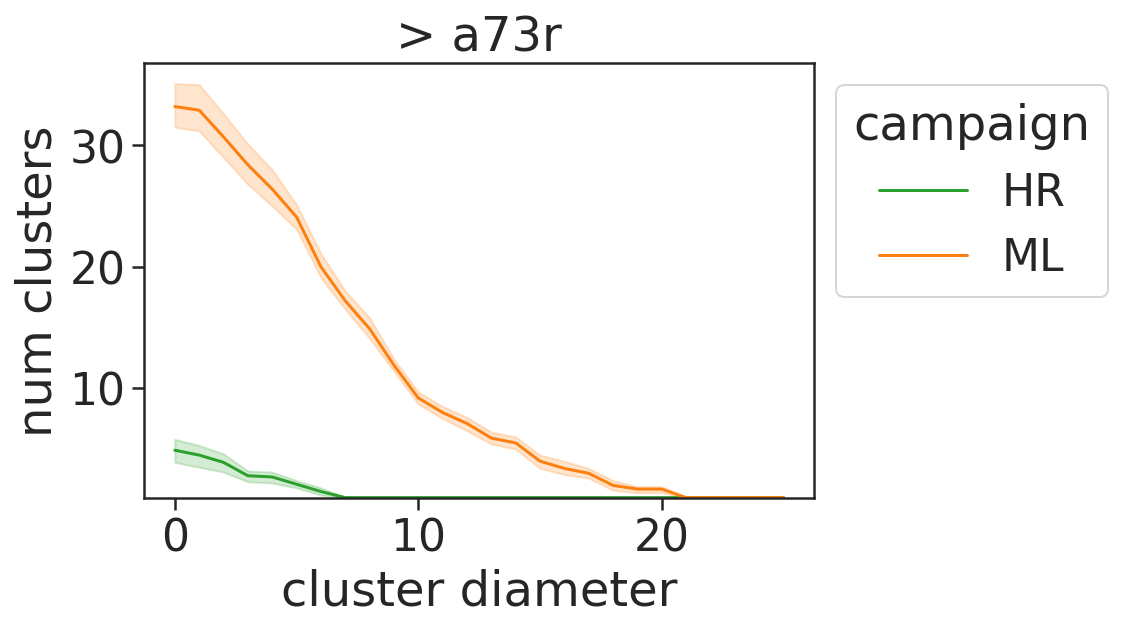

In [ ]:
for activity_label in num_clusters_g4_df['activity_label'].unique():
  plotdf = num_clusters_g4_df[
      num_clusters_g4_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='campaign',
      hue_order=['HR', 'ML'],
      palette=[plotting.HR_COLOR, plotting.ML_COLOR],
  )
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.xlabel('cluster diameter')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylim(bottom=1.0)
  plt.show()

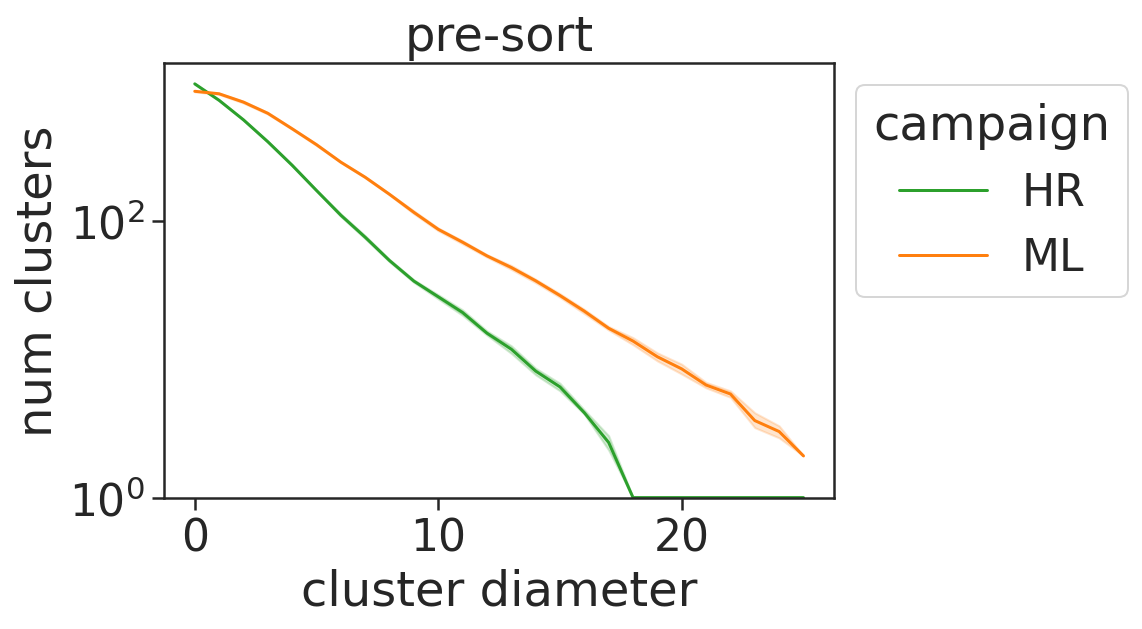

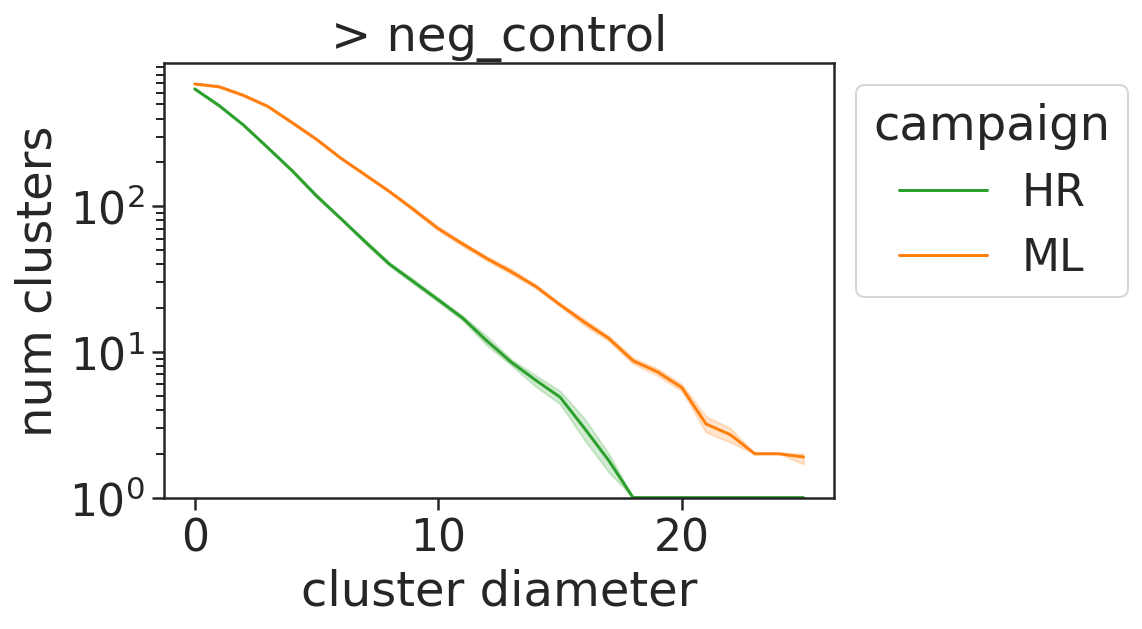

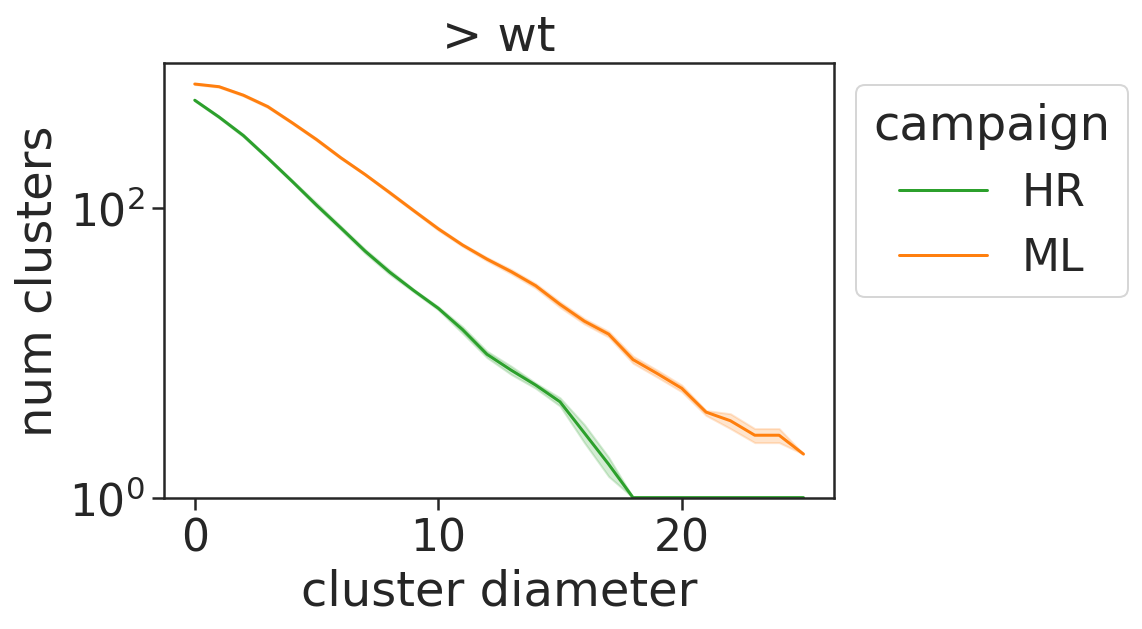

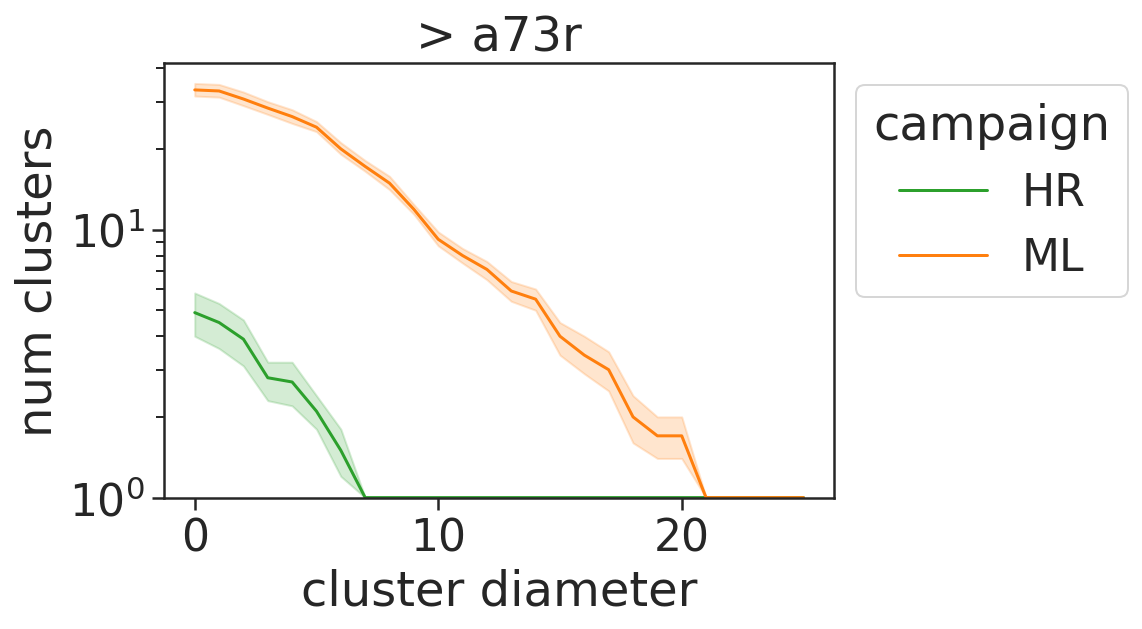

In [ ]:
for activity_label in num_clusters_g4_df['activity_label'].unique():
  plotdf = num_clusters_g4_df[
      num_clusters_g4_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='campaign',
      hue_order=['HR', 'ML'],
      palette=[plotting.HR_COLOR, plotting.ML_COLOR],
  )
  ax.set(yscale='log')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylabel('num clusters')
  plt.xlabel('cluster diameter')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylim(bottom=1.0)
  plt.show()

### overlaid with full library clustering

(1.0, 1000.0)

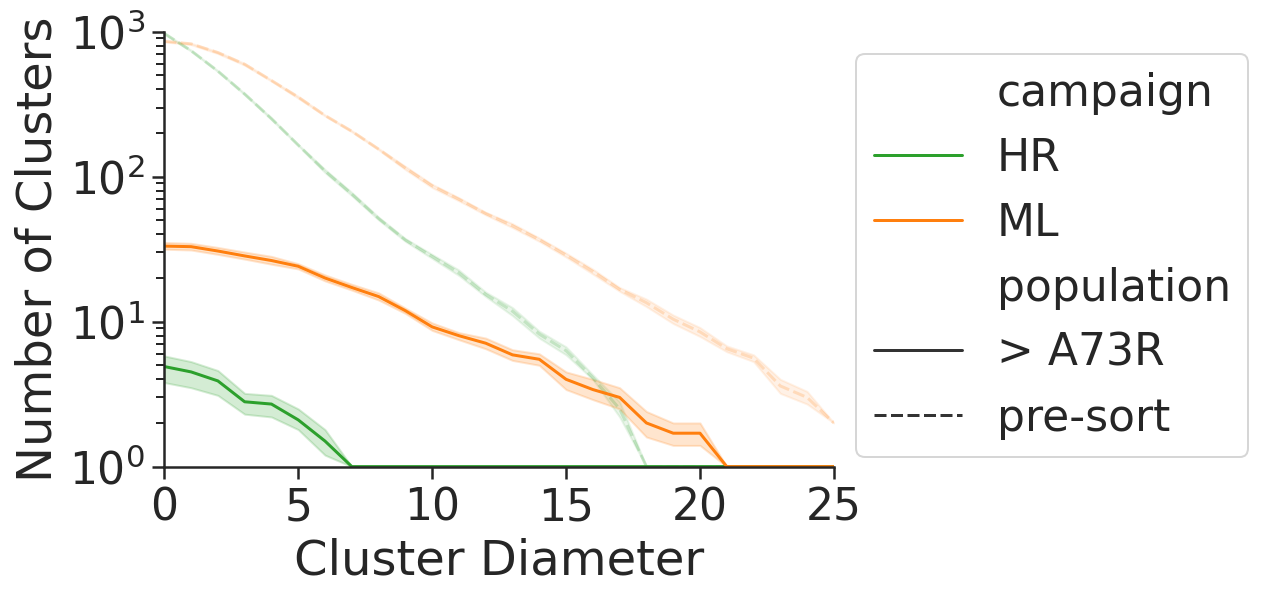

In [ ]:
plotting.make_diversity_overlay_plot(
    num_clusters_g4_df, '> A73R', 'campaign', ['HR', 'ML'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
)
plt.ylim(top=10e2)

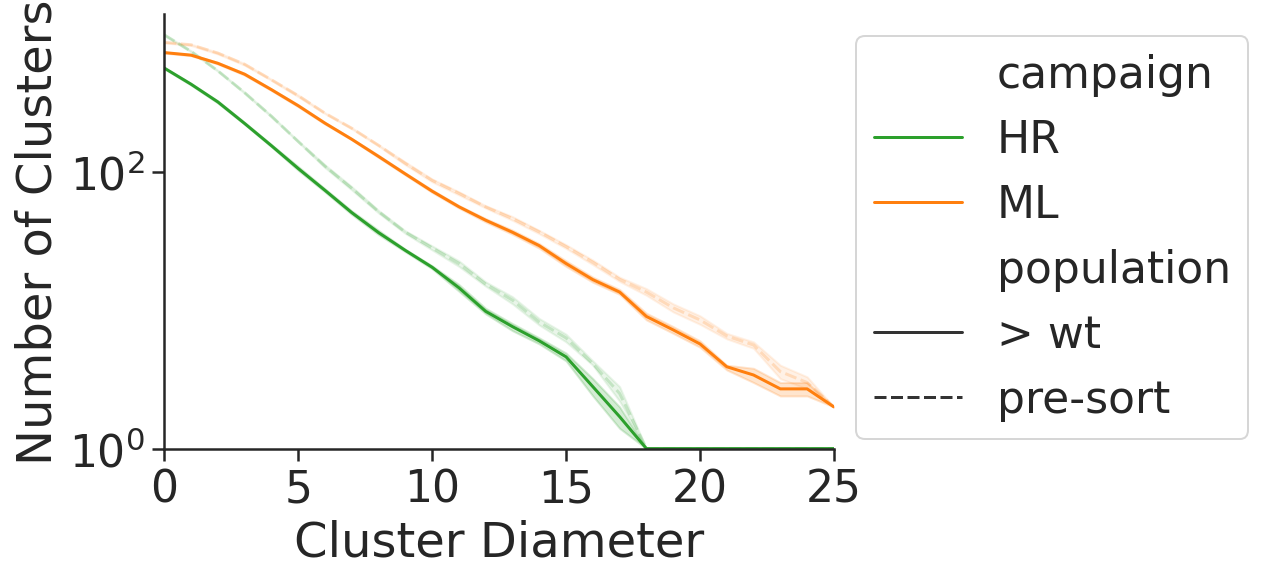

In [ ]:
plotting.make_diversity_overlay_plot(
    num_clusters_g4_df, '> wt', 'campaign', ['HR', 'ML'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
)

# Zero-shot

In [ ]:
g1_df = df[df.generation == 'g1'].reset_index(drop=True)

In [ ]:
zero_shot_and_g1_df = pd.concat([df[df['sublibrary_name'] == 'zero_shot'], g1_df])

In [ ]:
hit_calling_kwargs = dict(
    reference_name='wt', expected_false_discovery_rate=utils.EXPECTED_FDR
)
print_library_sizes(zero_shot_and_g1_df, hit_calling_kwargs)

Input library
size:
g1_eppcr     9441
zero_shot    1235
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g1_eppcr     3167
zero_shot     448
Name: sequence, dtype: int32
Hits
size:
g1_eppcr     155
zero_shot    134
Name: sublibrary_name, dtype: int64
num clusters:
sublibrary_name
g1_eppcr     33
zero_shot    74
Name: sequence, dtype: int32


In [ ]:
# add pre-sort label
num_clusters_zero_shot_df['activity_label'] = num_clusters_zero_shot_df['activity_label'].apply(lambda x: 'pre-sort' if x == 'all' else x)

In [ ]:
# rename activity_label to population
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['activity_label'].astype(str)
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('a73r', 'A73R')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('neg_control', 'negative control')
num_clusters_zero_shot_df['population'] = num_clusters_zero_shot_df['population'].str.replace('wt', 'parent')

In [ ]:
num_clusters_zero_shot_df.head()

,sublibrary_name,level_1,num_clusters,activity_label,max_intra_cluster_hamming_distance,population
0,g1_eppcr,0,5990,pre-sort,0,pre-sort
1,g1_eppcr,1,5981,pre-sort,0,pre-sort
2,g1_eppcr,2,5889,pre-sort,0,pre-sort
3,g1_eppcr,3,5961,pre-sort,0,pre-sort
4,g1_eppcr,4,5977,pre-sort,0,pre-sort


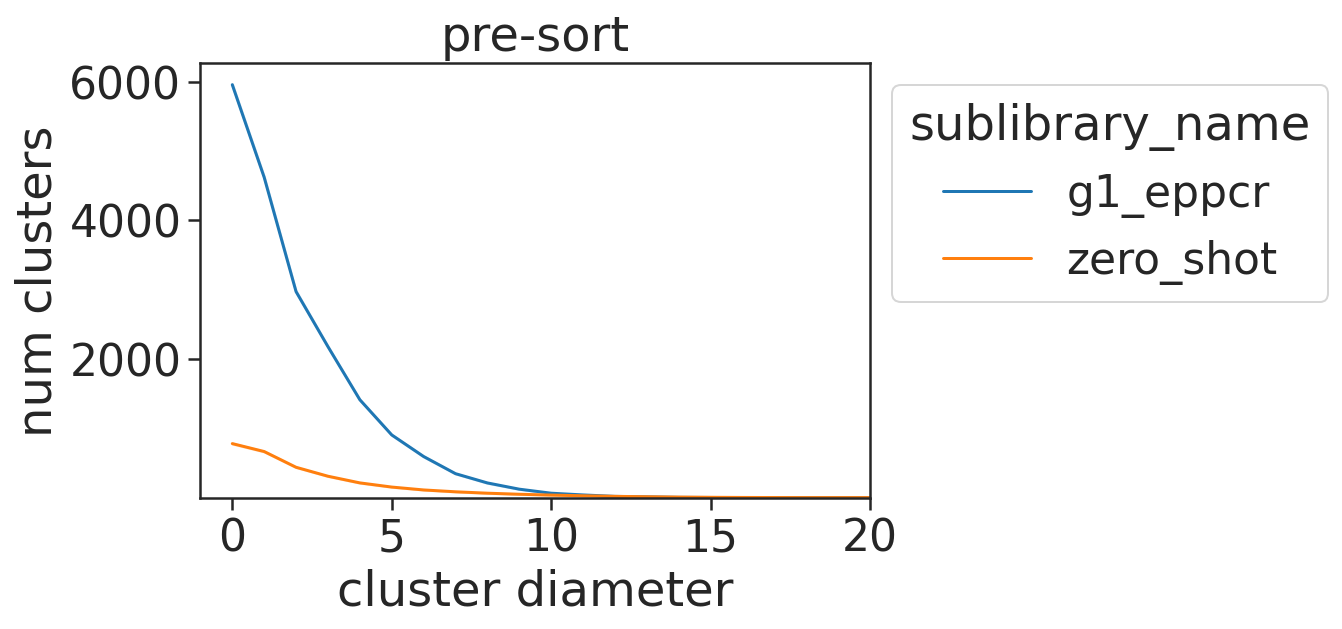

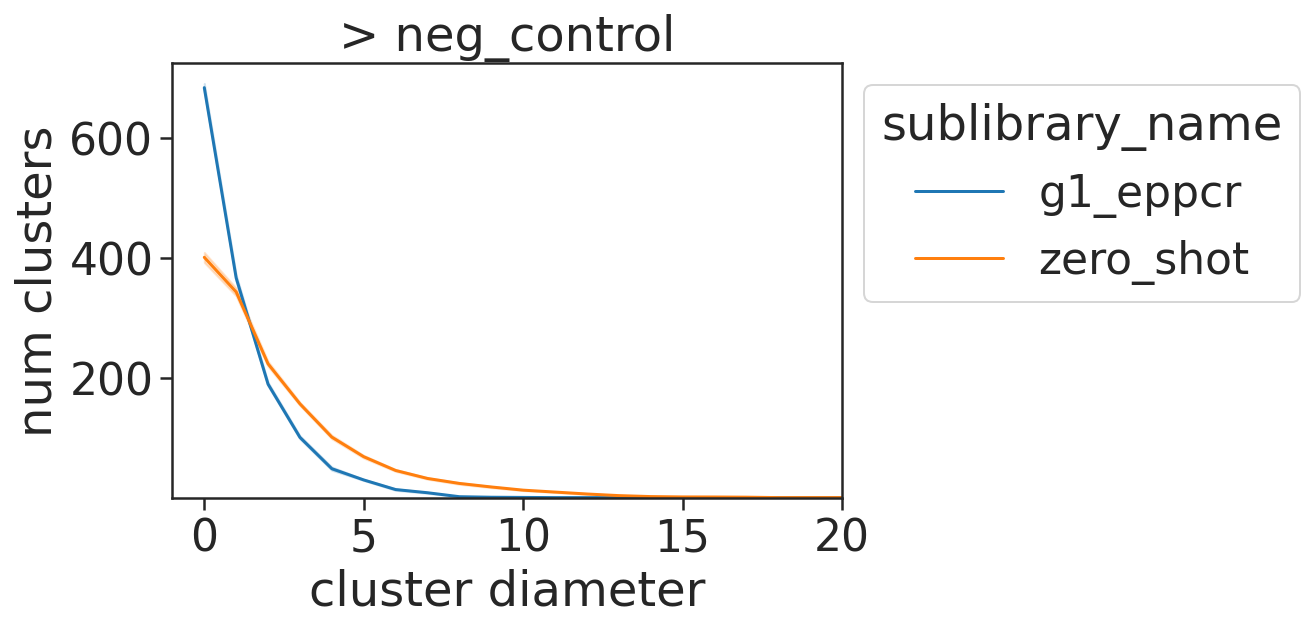

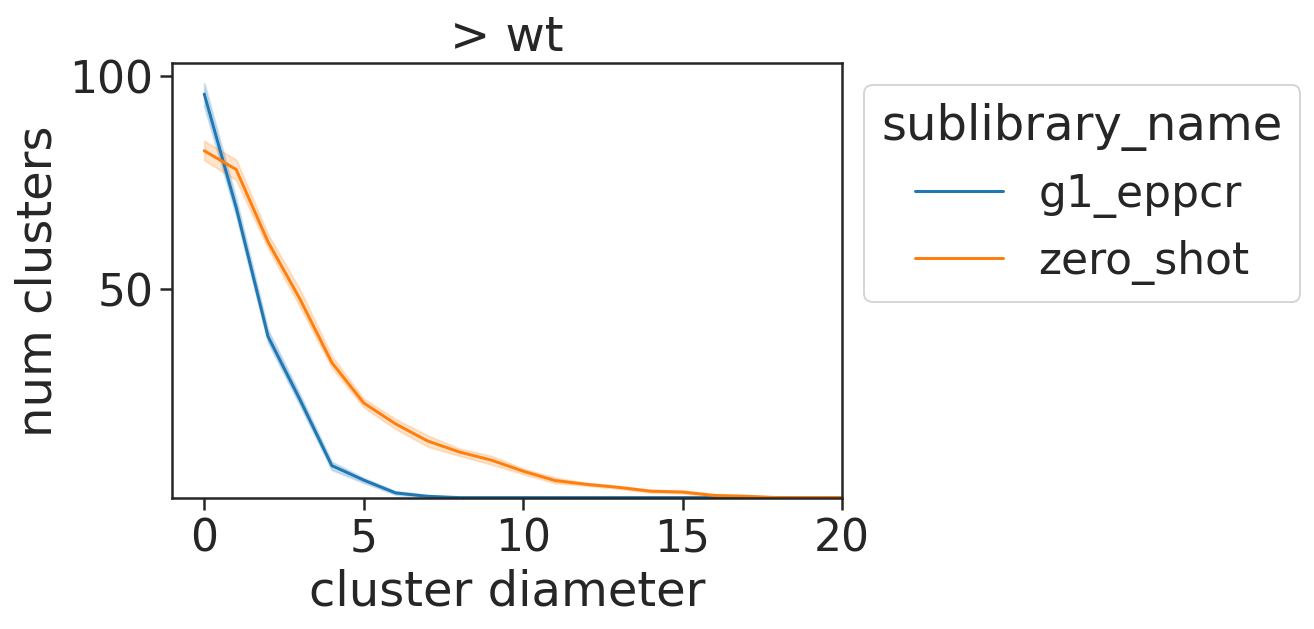

In [ ]:
for activity_label in num_clusters_zero_shot_df['activity_label'].unique():
  plotdf = num_clusters_zero_shot_df[
      num_clusters_zero_shot_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='sublibrary_name',
      palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
  )
  plotting.remove_underscores_from_axis_labels(ax)
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.xlabel('cluster diameter')
  plt.ylim(bottom=1.0)
  plt.xlim(right=20)
  plt.show()

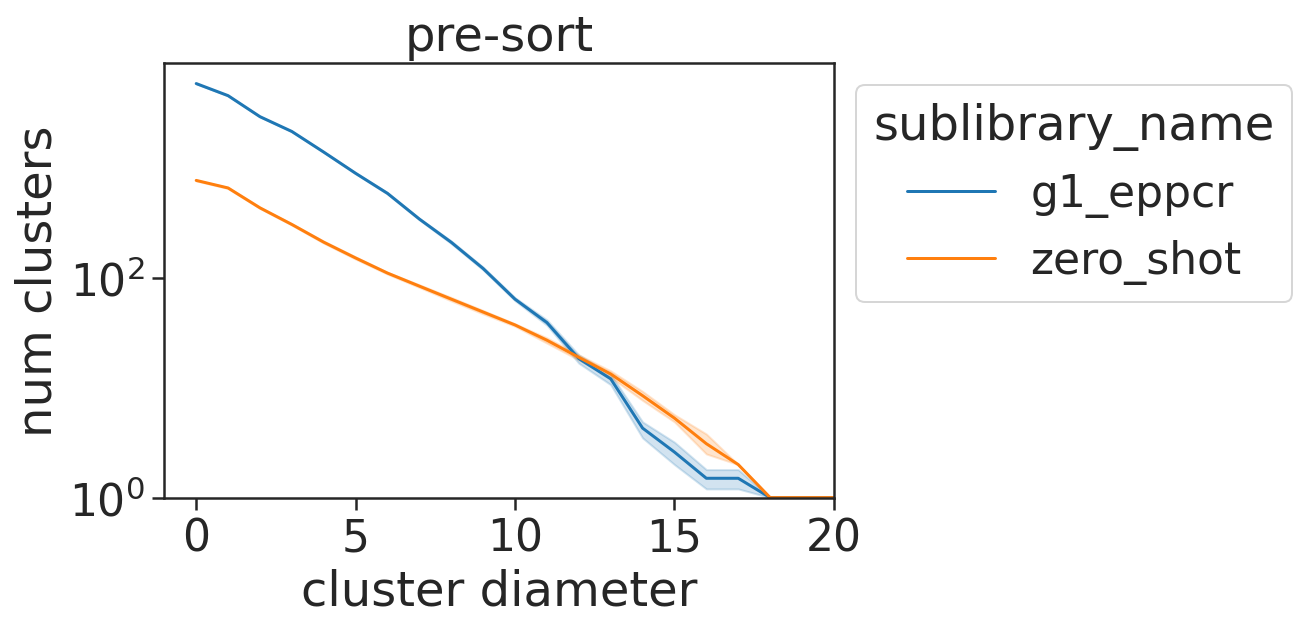

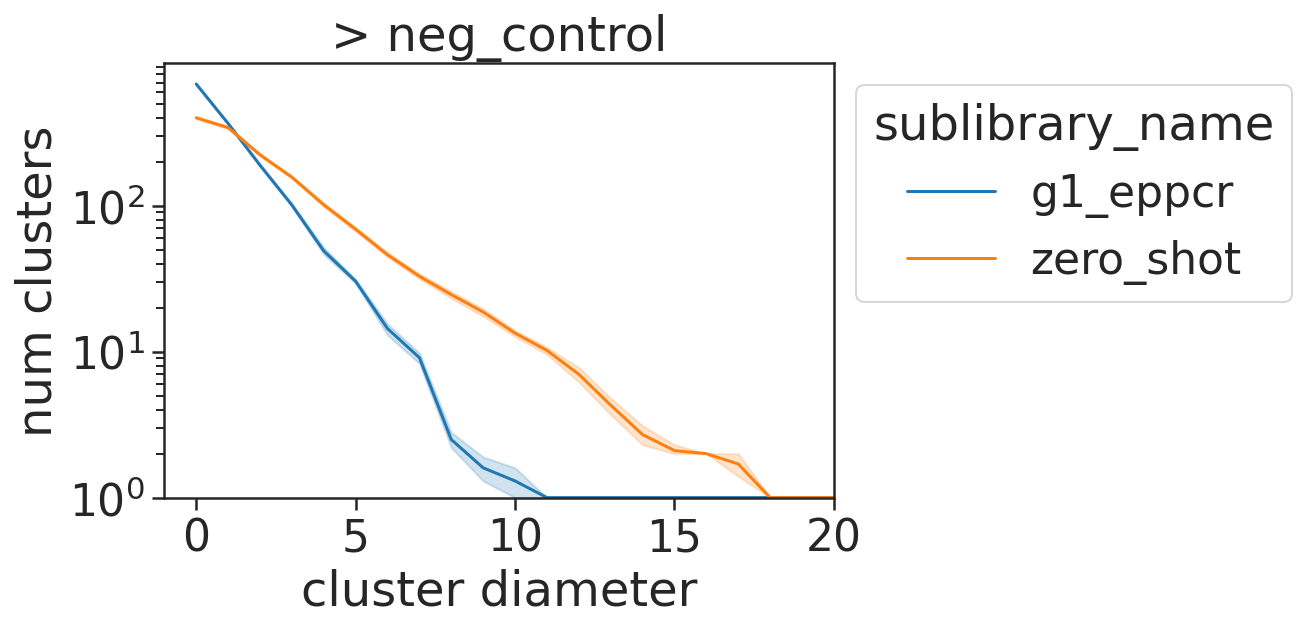

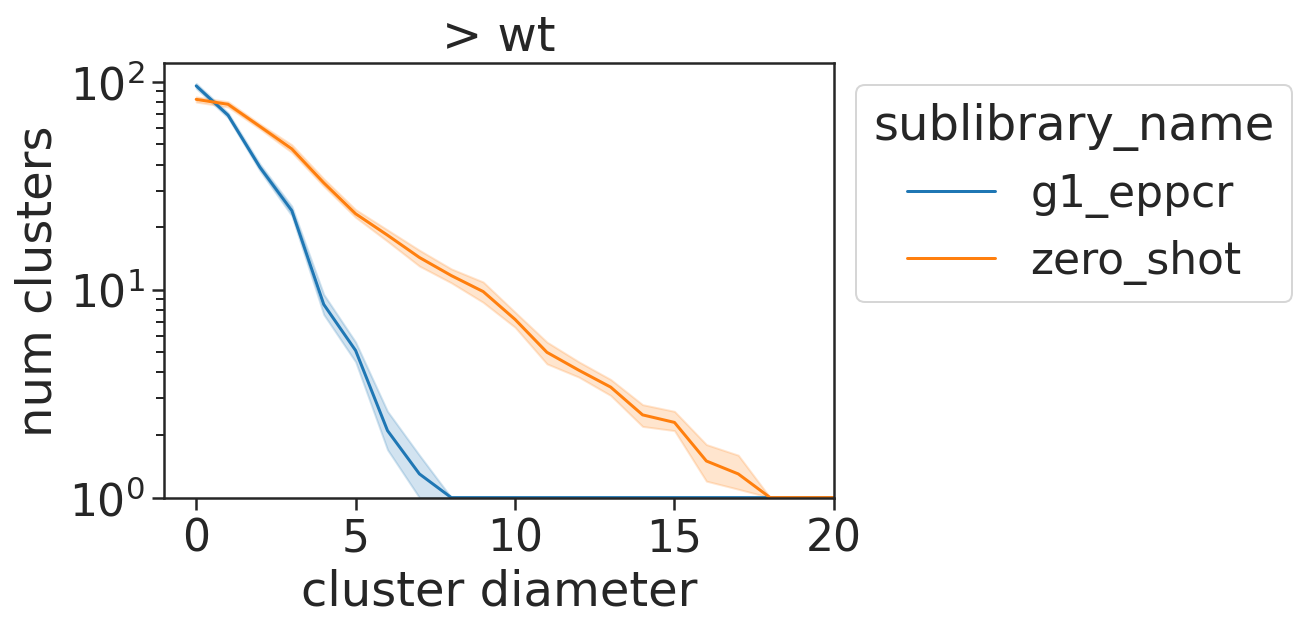

In [ ]:
for activity_label in num_clusters_zero_shot_df['activity_label'].unique():
  plotdf = num_clusters_zero_shot_df[
      num_clusters_zero_shot_df['activity_label'] == activity_label
  ]
  ax = sns.lineplot(
      data=plotdf,
      x='max_intra_cluster_hamming_distance',
      y='num_clusters',
      hue='sublibrary_name',
      palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
  )
  ax.set(yscale='log')
  plotting.remove_underscores_from_axis_labels(ax)
  plt.ylabel('num clusters')
  plt.xlabel('cluster diameter')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.title(activity_label)
  plt.ylim(bottom=1.0)
  plt.xlim(right=20)
  plt.show()

(1.0, 10000.0)

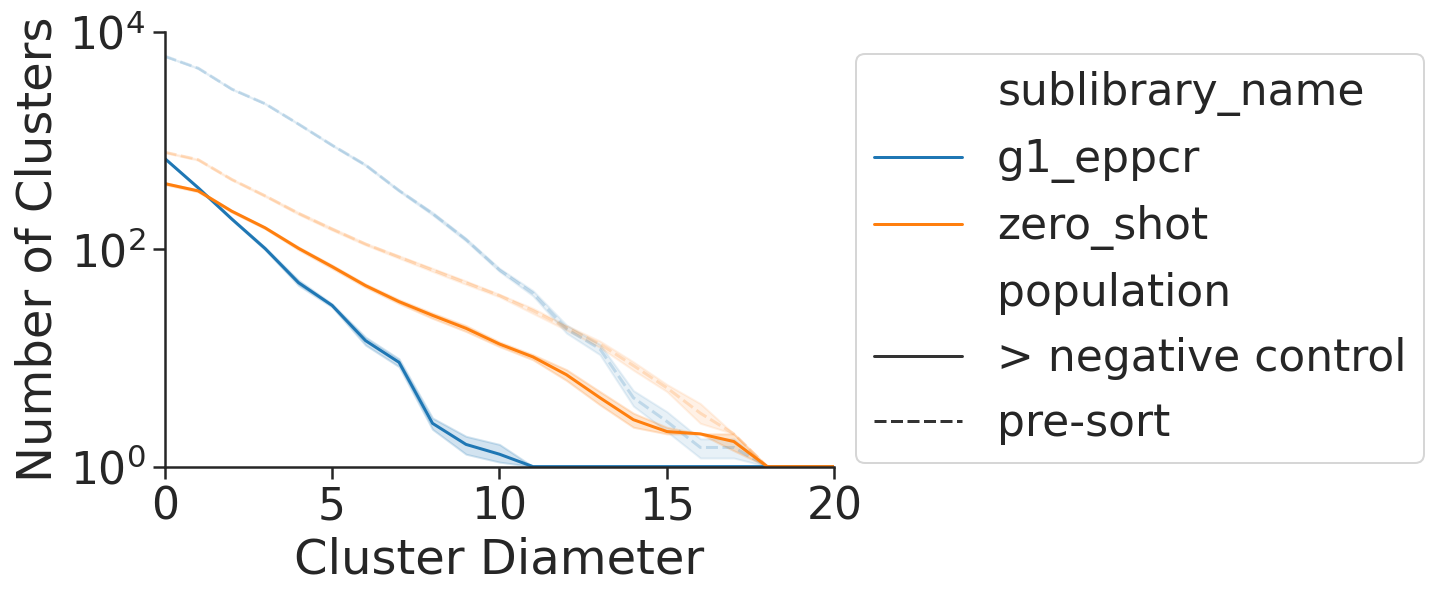

In [ ]:
plotting.make_diversity_overlay_plot(
    num_clusters_zero_shot_df,
    '> negative control',
    'sublibrary_name',
    ['g1_eppcr', 'zero_shot'],
    palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
    xticks_max=21,
)
plt.ylim(top=10e3)

(1.0, 10000.0)

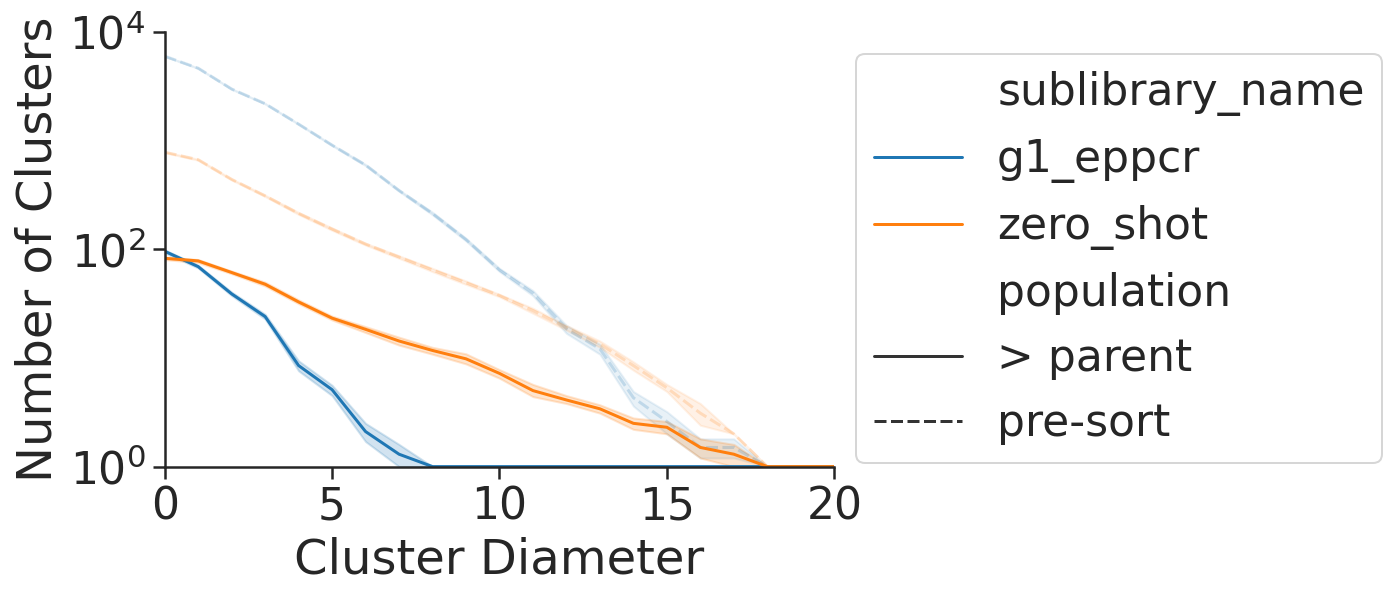

In [ ]:
plotting.make_diversity_overlay_plot(
    num_clusters_zero_shot_df,
    '> parent',
    'sublibrary_name',
    ['g1_eppcr', 'zero_shot'],
    palette=[plotting.EPPCR_COLOR, plotting.ML_COLOR],
    xticks_max=21,
)
plt.ylim(top=10e3)